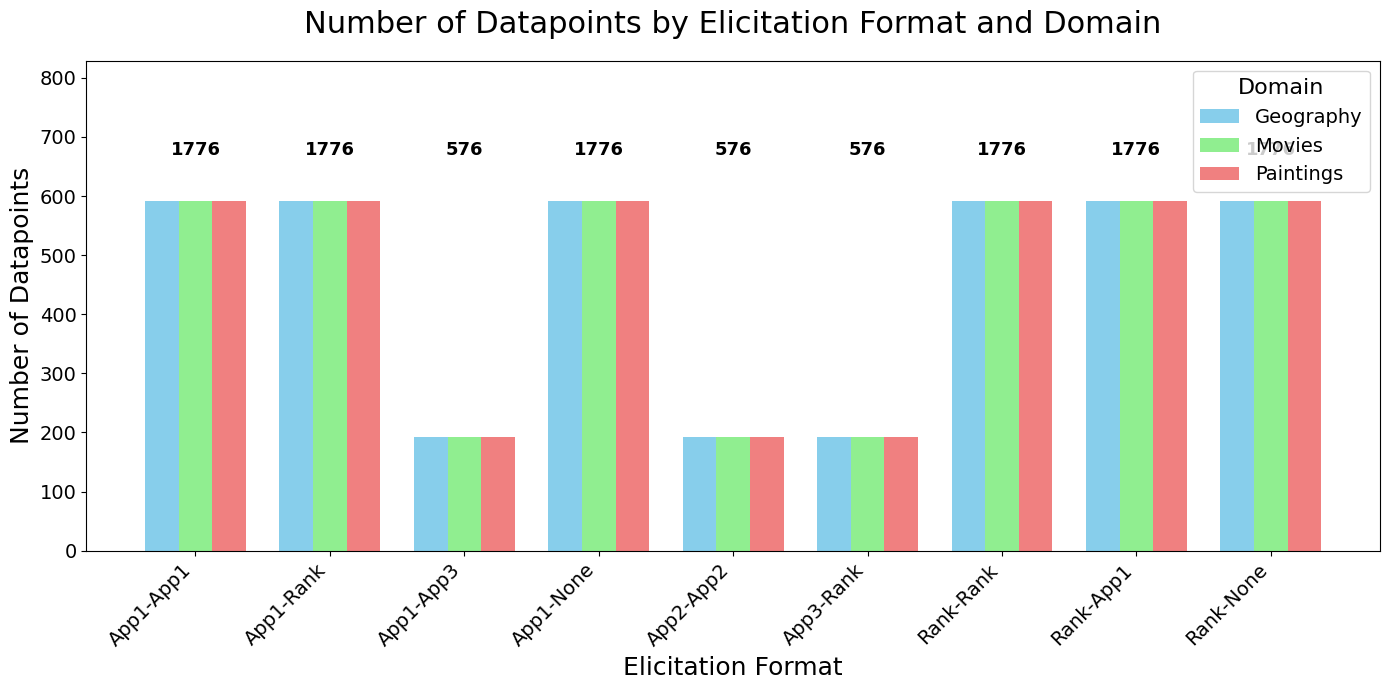

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('SP_Rank_Dataset.csv')
df.columns = df.columns.str.lower()

# Safe evaluation for stringified lists
def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

df['votes'] = df['votes'].apply(safe_eval)
df['options'] = df['options'].apply(safe_eval)

# Map domain IDs to names
domain_mapping = {
    1: 'Geography',
    2: 'Movies',
    3: 'Paintings'
}

if df['domain'].dtype in [np.int64, np.int32, int]:
    df['domain'] = df['domain'].map(domain_mapping)


counts = df.groupby(['elicitation_format', 'domain']).size().unstack(fill_value=0)

# reorder formats manually if needed
order = ['top-top', 'top-rank', 'top-approval3', 'top-none', 
         'approval2-approval2', 'approval3-rank', 
         'rank-rank', 'rank-top', 'rank-none']
order = [fmt for fmt in order if fmt in counts.index]
counts = counts.loc[order]

# Shorten labels
shorten_mapping = {
    'approval2-approval2': 'App2-App2',
    'approval3-rank': 'App3-Rank',
    'top-approval3': 'App1-App3',
    'rank-none': 'Rank-None',
    'rank-top': 'Rank-App1',
    'rank-rank': 'Rank-Rank',
    'top-none': 'App1-None',
    'top-top': 'App1-App1',
    'top-rank': 'App1-Rank'
}
counts.index = [shorten_mapping.get(fmt, fmt) for fmt in counts.index]

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

domains = ['Geography', 'Movies', 'Paintings']
colors = ['skyblue', 'lightgreen', 'lightcoral']
x = np.arange(len(counts.index))  # one spot per elicitation format
width = 0.25

# Plot each domain
for idx, (domain, color) in enumerate(zip(domains, colors)):
    ax.bar(x + (idx - 1) * width, counts[domain], width, label=domain, color=color)


ax.set_ylabel('Number of Datapoints', fontsize=18)
ax.set_xlabel('Elicitation Format', fontsize=18)
ax.set_title('Number of Datapoints by Elicitation Format and Domain', fontsize=22, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(counts.index, rotation=45, ha='right', fontsize=14)
ax.legend(title='Domain', fontsize=14, title_fontsize=16)
ax.set_ylim(0, counts.values.max() * 1.4)
ax.tick_params(axis='y', labelsize=14)


for idx_fmt, format_ in enumerate(counts.index):
    total = counts.loc[format_].sum()
    ax.annotate(f'{total}', 
                xy=(idx_fmt, counts.values.max() * 1.1), 
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=13, fontweight='bold', color='black')

plt.tight_layout()
#plt.savefig('datapoints_per_domain_per_elicitation_format.pdf')
#plt.close()
plt.show()

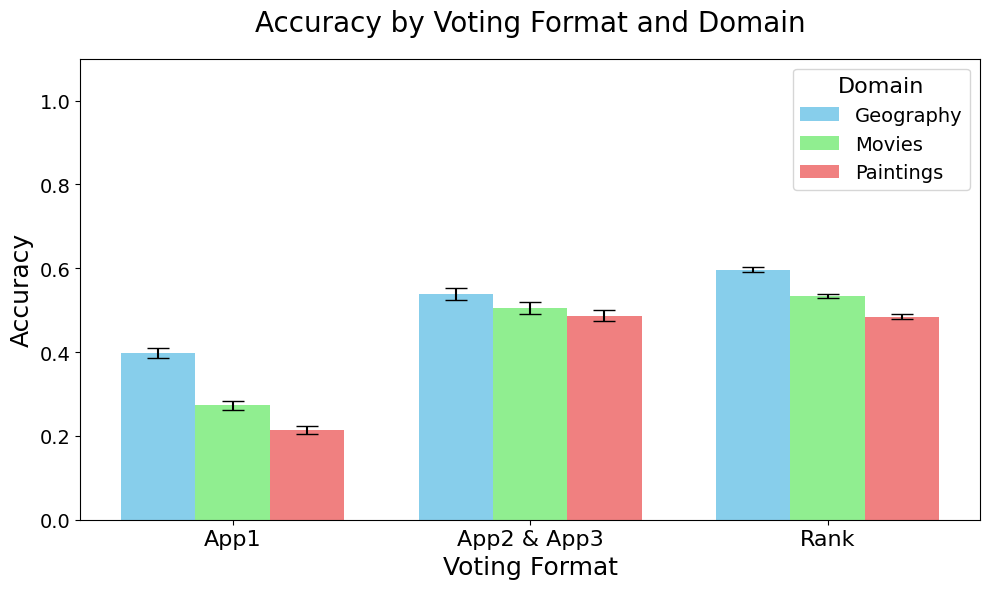

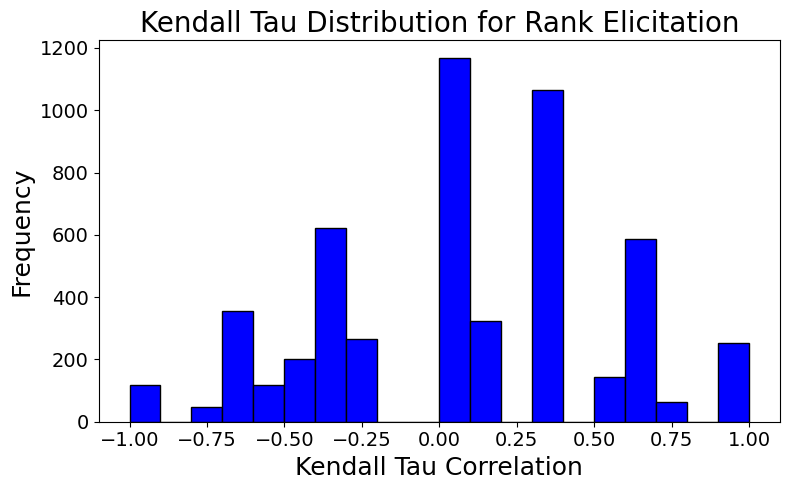

count    5328.000000
mean        0.076852
std         0.470396
min        -1.000000
25%        -0.333333
50%         0.000000
75%         0.333333
max         1.000000
Name: kendall_tau, dtype: float64


In [3]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import numpy as np

# Load the dataset
df = pd.read_csv('SP_Rank_Dataset.csv')
df.columns = df.columns.str.lower()

# Safe evaluation for stringified lists
def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

df['votes'] = df['votes'].apply(safe_eval)
df['options'] = df['options'].apply(safe_eval)

# Extract vote part of elicitation_format
df['vote_format'] = df['elicitation_format'].str.split('-').str[0]

domain_mapping = {
    1: 'Geography',
    2: 'Movies',
    3: 'Paintings'
}
if df['domain'].dtype in [np.int64, np.int32, int]:
    df['domain'] = df['domain'].map(domain_mapping)


def check_accuracy(row):
    fmt = row['vote_format']
    vote = row['votes']
    options = row['options']

    if not vote or not options:
        return 0

    # Approval1/Top voting format
    if fmt == 'top':
        return int(vote[0] == options[0])

    # Approval2 format
    elif fmt == 'approval2':
        top2_gt = set(options[:2])
        return len([v for v in vote if v in top2_gt]) / 2

    # Approval3 format
    elif fmt == 'approval3':
        top3_gt = set(options[:3])
        return len([v for v in vote if v in top3_gt]) / 3

    # Rank voting format 
    elif fmt == 'rank':
        if len(vote) != len(options):
            return 0

        correct_pairs = 0
        total_pairs = 0
        option_indices = {option: idx for idx, option in enumerate(options)}
        vote_indices = {option: idx for idx, option in enumerate(vote)}

        for i in range(len(options)):
            for j in range(i + 1, len(options)):
                total_pairs += 1
                if (option_indices[options[i]] < option_indices[options[j]] and
                    vote_indices[options[i]] < vote_indices[options[j]]) or \
                   (option_indices[options[i]] > option_indices[options[j]] and
                    vote_indices[options[i]] > option_indices[options[j]]):
                    correct_pairs += 1

        return correct_pairs / total_pairs if total_pairs > 0 else 0

    return 0

df['accuracy'] = df.apply(check_accuracy, axis=1)

# Group by vote_format and domain
grouped = df.groupby(['vote_format', 'domain'])['accuracy'].agg(['mean', 'count', 'std'])
grouped.rename(columns={'mean': 'mean_accuracy', 'std': 'std_dev'}, inplace=True)
grouped['std_error'] = grouped['std_dev'] / np.sqrt(grouped['count'])

formats = ['top', 'approval', 'rank']
domains = ['Geography', 'Movies', 'Paintings']
domain_colors = ['skyblue', 'skyblue', 'skyblue']  # all same color

# Prepare data
plot_data = {}

# Approval combines approval2 and approval3
approval_data = df[df['vote_format'].isin(['approval2', 'approval3'])]
approval_grouped = approval_data.groupby('domain')['accuracy'].agg(['mean', 'count', 'std'])
approval_grouped.rename(columns={'mean': 'mean_accuracy', 'std': 'std_dev'}, inplace=True)
approval_grouped['std_error'] = approval_grouped['std_dev'] / np.sqrt(approval_grouped['count'])

# Fill plot_data
for fmt in formats:
    plot_data[fmt] = []
    for domain in domains:
        if fmt == 'approval':
            row = approval_grouped.loc[domain]
        else:
            row = grouped.loc[(fmt, domain)]
        plot_data[fmt].append((row['mean_accuracy'], row['std_error']))

# Bar plot settings
x = np.arange(len(formats))  # Top, Approval, Rank
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Set different colors for each domain
domain_colors = ['skyblue', 'lightgreen', 'lightcoral']

for idx, (domain, color) in enumerate(zip(domains, domain_colors)):
    means = [plot_data[fmt][idx][0] for fmt in formats]
    errors = [plot_data[fmt][idx][1] for fmt in formats]
    ax.bar(x + idx * width - width, means, width, label=domain, yerr=errors, capsize=8, color=color)

# Labels
ax.set_ylabel('Accuracy', fontsize=18)
ax.set_xlabel('Voting Format', fontsize=18)
ax.set_title('Accuracy by Voting Format and Domain', fontsize=20, pad=20)
ax.set_xticks(x)
custom_labels = {'top': 'App1', 'approval': 'App2 & App3', 'rank': 'Rank'}
ax.set_xticklabels([custom_labels[fmt] for fmt in formats], fontsize=16)
ax.legend(title='Domain', fontsize=14, title_fontsize=16)
ax.set_ylim(0, 1.1)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
#plt.savefig('accuracy_per_format_per_domain.pdf')
#plt.close()
plt.show()


# Filter only Rank format rows
rank_df = df[df['vote_format'] == 'rank'].copy()

def compute_kendall(row):
    vote = row['votes']
    options = row['options']
    if len(vote) == len(options) and len(vote) > 1:
        tau, _ = kendalltau(vote, options)
        return tau
    else:
        return np.nan

rank_df['kendall_tau'] = rank_df.apply(compute_kendall, axis=1)
rank_df = rank_df.dropna(subset=['kendall_tau'])

plt.figure(figsize=(8, 5))
plt.hist(rank_df['kendall_tau'], bins=20, color='blue', edgecolor='black')
plt.title('Kendall Tau Distribution for Rank Elicitation', fontsize=20)
plt.xlabel('Kendall Tau Correlation', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
#plt.savefig('kendall_tau_distribution_rank.pdf')
#plt.close()
plt.show()
print(rank_df['kendall_tau'].describe())
